In [1]:
import glicko2 as Glicko

In [2]:
# improbable results are likely so set tau low
tau = 0.2
phi = 250
sigma = 0.1
mu_decay_factor = 0.999

In [3]:
glck = Glicko.Glicko2(tau=tau, phi=phi, sigma=sigma)

In [4]:
import pandas as pd
import math
import numpy as np

In [5]:
naf_data = pd.read_csv("data/NAF_games.csv.gz", sep=",", 
                       parse_dates=['date'], index_col=3)

naf_data.sort_values("date", inplace=True)

In [6]:
naf_data.head()

,tournamentname,tournamentnation,tournamentcity,HomeCoachNAFname,HomeCoachNAFid,HomeRace,goalshome,AwayCoachNAFname,AwayCoachNAFid,AwayRace,goalsaway,date
gameid,,,,,,,,,,,,
8572,The Dutch Open 2003,Netherlands,Amsterdam,Gorbad,152,Wood Elves,1,dolferl,126,Dark Elves,5,2003-01-02 12:00:00
8571,The Dutch Open 2003,Netherlands,Amsterdam,Norse,144,Dwarves,2,Skevan,136,Norse,0,2003-01-02 12:00:00
8557,The Dutch Open 2003,Netherlands,Amsterdam,playfulhands,148,Wood Elves,3,grep_v,142,Chaos Dwarves,2,2003-01-02 12:00:00
8558,The Dutch Open 2003,Netherlands,Amsterdam,madhobbit,130,Undead,1,Zy_Nox,86,Undead,1,2003-01-02 12:00:00
8559,The Dutch Open 2003,Netherlands,Amsterdam,Longshot,101,Wood Elves,3,Redfang,143,Dwarves,1,2003-01-02 12:00:00


In [7]:
home = naf_data[["HomeCoachNAFid", "HomeCoachNAFname"]].drop_duplicates()
away = naf_data[["AwayCoachNAFid", "AwayCoachNAFname"]].drop_duplicates()
away.columns = home.columns

In [8]:
# create lookup table
# inefficient, but hey ho
dd = pd.concat([home, away], axis=0)
dd= dd.set_index("HomeCoachNAFid")

In [9]:
lookup = dd.to_dict()["HomeCoachNAFname"]

In [10]:
ranking_periods = pd.date_range(naf_data.iloc[0].date - pd.offsets.MonthBegin(1), 
                                naf_data.iloc[-1].date + pd.offsets.MonthBegin(1), 
                                freq='1M')

In [11]:
counter=0
ranking_data = dict()

for start, stop in zip(ranking_periods[:-1], ranking_periods[1:]):
    
    new_ranking = dict()
    
    start_ix = naf_data.date.searchsorted(start)[0]
    stop_ix = naf_data.date.searchsorted(stop)[0]
    
    # extract just games in this period
    d = naf_data[start_ix:stop_ix]
    
    # drop irrelevent fields
    x = d.drop(["tournamentname", "tournamentnation", "tournamentcity", 
                "HomeCoachNAFname", "AwayCoachNAFname", "date"], axis=1).copy()
    
    # duplicate- as we have to handle both players
    y = x.ix[:, [3, 4, 5, 0, 1, 2]].copy()
    y.columns = x.columns
    x = pd.concat([x, y], axis=0)

    # create new result column
    x["result"] = np.where(x.goalshome > x.goalsaway, 1, 
                           np.where(x.goalshome < x.goalsaway, 0, 0.5)) 
    
    # group by player
    grped = x.groupby("HomeCoachNAFid")
    
    # first run through all players who have played in this period
    for player in grped.groups:
        
        new_ranking[player] = dict()
        
        # all games played by player X
        data = grped.get_group(player)
        
        # if new player...
        if player not in ranking_data:
            ranking_data[player] = dict()
            
        # now loop through races...
        byrace = data.groupby("HomeRace")
        for played_race in byrace.groups:

            games = byrace.get_group(played_race)
            series = list()

            for oppo_id, oppo_race, result in zip(games.AwayCoachNAFid, 
                                                  games.AwayRace, 
                                                  games.result):

                if oppo_id not in ranking_data:
                    ranking_data[oppo_id] = dict()

                if oppo_race not in ranking_data[oppo_id]:
                    ranking_data[oppo_id][oppo_race] = glck.create_rating()

                series.append((result, ranking_data[oppo_id][oppo_race]))

            # now rate
            if played_race not in ranking_data[player]:
                ranking_data[player][played_race] = glck.create_rating()

            new_ranking[player][played_race] = glck.rate(ranking_data[player][played_race], series)

    # now through all players: if not played then increment their phi
    for player, rankings in ranking_data.items():
        
        assert len(rankings) > 0
            
        for race, rank in rankings.items():
            played = False
        
            if player not in new_ranking:
                # if not in new ranking, then cannot have played...
                new_ranking[player] = dict()
                
            if player in grped.groups:
                # might have played
                data = grped.get_group(player)
                byrace = data.groupby("HomeRace")
                if race in byrace.groups:
                    played = True
                
            if not played:
                # if he/she didn't play
                
                # transform into glicko space...
                dnp = glck.scale_down(ranking_data[player][race])
                
                # increment phi
                phi_star = math.sqrt(dnp.phi ** 2 + dnp.sigma ** 2)
                
                # shrink mu
                mu_star = dnp.mu * mu_decay_factor
                
                new_ranking[player][race] = glck.scale_up(
                    glck.create_rating(mu=mu_star, phi=phi_star, sigma=dnp.sigma))
            
#                 if (player == 149) and (race == "Amazons"):
#                     print(start, race, new_ranking[player][race])
                
    ranking_data = new_ranking
    counter += 1

## Parse data structure into something more tabular

In [12]:
d = list()

# for each player
for key, value in ranking_data.items():
    
    races = value.keys()
    pid = lookup.get(key, str(key))
    
    index = pd.MultiIndex.from_tuples([(pid, r) for i, r in enumerate(races)])
    
    df = pd.DataFrame(index=index, columns=["mu", "phi", "sigma"])
    
    # for each race played...
    for race in races:
        q = ranking_data[key][race]
        df.loc[pid, race] = (q.mu, q.phi, q.sigma)
    d.append(df)

In [13]:
combined_rankings = pd.concat(d)

In [14]:
combined_rankings["rating"] = combined_rankings.mu.values - 2*combined_rankings.phi.values

In [15]:
combined_rankings = combined_rankings.apply(pd.to_numeric)

In [16]:
combined_rankings.sort_values("rating", inplace=True, ascending=False)

In [17]:
combined_rankings[:30]

,,mu,phi,sigma,rating
Joemanji,Lizardmen,1883.976055,96.928026,0.099964,1690.120003
Pipey,Norse,1896.265500,103.561966,0.099986,1689.141569
Purplegoo,Humans,1870.363111,97.819967,0.099950,1674.723178
Pipey,Undead,1862.065135,98.583749,0.099996,1664.897637
AndyDavo,Dark Elves,1860.328315,97.938621,0.100019,1664.451073
kfoged,Dark Elves,1865.735696,100.817773,0.099956,1664.100150
Purplegoo,Vampires,1897.616338,120.464957,0.099992,1656.686425
Karaak,Lizardmen,1924.275936,133.910555,0.099993,1656.454826
Jimjimany,Wood Elves,1847.309822,97.021684,0.099926,1653.266453
bourpif,Undead,1845.417371,96.441915,0.099984,1652.533541


In [18]:
combined_rankings.xs("mubo")

,mu,phi,sigma,rating
Dark Elves,1813.867132,106.262438,0.100039,1601.342257
Wood Elves,1790.250585,115.612083,0.099980,1559.026420
Humans,1724.587014,125.233543,0.099993,1474.119928
Undead,1686.929991,125.658301,0.099987,1435.613389
Skaven,1735.190143,176.694873,0.100000,1381.800397
Chaos Pact,1641.898958,144.544771,0.099996,1352.809417
Elves,1653.275529,164.046665,0.099996,1325.182200
Orc,1616.042062,156.775959,0.099996,1302.490145
Dwarves,1589.194623,211.500870,0.100000,1166.192882
Necromantic,1495.232233,221.432434,0.099997,1052.367366


In [19]:
import seaborn as sns

In [20]:
%matplotlib inline

/home/njh/miniconda3/envs/science/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


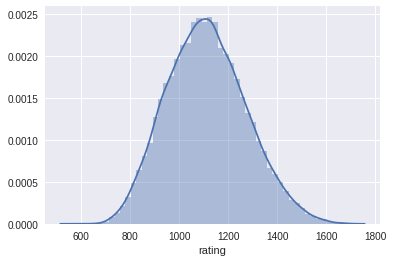

In [21]:
sns.distplot(combined_rankings.rating)

/home/njh/miniconda3/envs/science/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


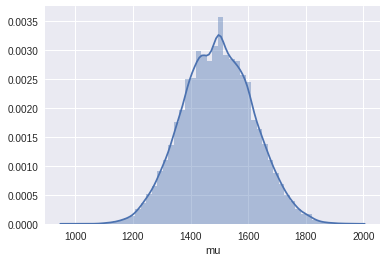

In [22]:
sns.distplot(combined_rankings.mu)

In [23]:
# algorithm:

# grab data in rating period. 2 months.

# reshape the data so 2 x the number of rows and home/away repeated. column for w/l/d
# 3 columns, playerID, oppoent, result

# group df by playerA id. 

# create a matrix of all the players who compet

